# Sentiment Analysis on Amazon Video Games Reviews

In this assignment we'll perform a sentiment analysis on video game reviews on Amazon. The goal is to create a model to algorithmically predict if a review is positive or negative just based on its text. We will also try to see how these reviews compare across categories by applying the models on a different Amazon reviews dataset which is a pet supplies revies. That will enable us to see if a review classification model for one category works for another. 

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import spacy
import time
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import Ridge, Lasso 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn import ensemble
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter


In [54]:
# Load and see the layout of the dataframe 
reviews_raw = pd.read_json('Video_Games_5.json', lines=True, encoding='utf-8')

reviews_raw.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,0700099867,"[8, 12]",1,Installing the game was a struggle (because of...,"07 9, 2012",A2HD75EMZR8QLN,123,Pay to unlock content? I don't think so.,1341792000
1,0700099867,"[0, 0]",4,If you like rally cars get this game you will ...,"06 30, 2013",A3UR8NLLY1ZHCX,"Alejandro Henao ""Electronic Junky""",Good rally game,1372550400
2,0700099867,"[0, 0]",1,1st shipment received a book instead of the ga...,"06 28, 2014",A1INA0F5CWW3J4,"Amazon Shopper ""Mr.Repsol""",Wrong key,1403913600
3,0700099867,"[7, 10]",3,"I got this version instead of the PS3 version,...","09 14, 2011",A1DLMTOTHQ4AST,ampgreen,"awesome game, if it did not crash frequently !!",1315958400
4,0700099867,"[2, 2]",4,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600


## About the data

The dataset consists of a more than 230K Amazon customer reviews, product rating, and helpful score which measures how helpful other users found the reviews. The dataset can be downloaded on the link below.

http://jmcauley.ucsd.edu/data/amazon/ 

<li>Variables</li>

<ul>reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B</ul>
<ul>asin - ID of the product, e.g. 0000013714</ul>
<ul>reviewerName - name of the reviewer</ul>
<ul>helpful - helpfulness rating of the review, e.g. 2/3</ul>
<ul>reviewText - text of the review</ul>
<ul>overall - rating of the product</ul>
<ul>summary - summary of the review</ul>
<ul>unixReviewTime - time of the review (unix time)</ul>
<ul>reviewTime - time of the review (raw)</ul>

## Approach to data preparation and feature selection. 

We will use the 'reviewText' to build classification models. First we will use the 'helpful' variable to isoate only the reviews which are useful to users. Then we will use the 'overall' variable (which is product rating) to categorize the sentiment in to positive and negative. We can then use the words in these two categories to train our models. 

In [55]:
# no NaN values in the columns we're interested in 
reviews_raw.isnull().sum()

asin                 0
helpful              0
overall              0
reviewText           0
reviewTime           0
reviewerID           0
reviewerName      2813
summary              0
unixReviewTime       0
dtype: int64

The 'helpful' entry can be used to generate a score between 0 and 1 (not including 1) by dividing the first number by te second. We will remove zero denominators to avoid division error. 

In [58]:
# we started with this many reviews 
reviews_raw.shape

(231780, 11)

In [57]:
# Separate the values and divide them to get a score
reviews_raw[['relevance_Numerator','relevance_Denominator']] = pd.DataFrame(reviews_raw.helpful.values.tolist(), index = reviews_raw.index)

In [62]:
# Make a score of the 'helpful' rating max value is 1. This number can be used to filter out non helpful reviews based on a 
# treshold.
reviews_raw['relevance'] = np.where(reviews_raw['relevance_Denominator'] > 0, reviews_raw['relevance_Numerator'] / reviews_raw['relevance_Denominator'], -1)

In [59]:
# Zero people found this review important 
reviews_raw= reviews_raw[reviews_raw['relevance_Denominator'] > 0]

In [60]:
# A significant number of reviews do not have 'helpful' ratings by other users
# We will loose some information but we will be resampling anyways for class imbalance
reviews_raw.shape

(139855, 11)

We can now categorize reviews as relevant and non relevant. We'll drop non relevant reviews and then use overall score to separate positive and negative sentiment.  In our case we will just use a helpful index of 75%. 
<b>Note:</b> Any value above 50% would still be justified but I picked 75% only because of the need to reduce the data. The processing power of the computer used to make this assignment is not good enough to run some of te models. 

In [64]:
# Separate the relevant and non-relevant reviews.  
reviews_raw['relevance']=np.where(reviews_raw['relevance'] >= 0.75, 1, reviews_raw['relevance'].astype(int))
reviews_raw['relevance']=np.where(reviews_raw['relevance'] < 0.75, 0, reviews_raw['relevance'].astype(int))

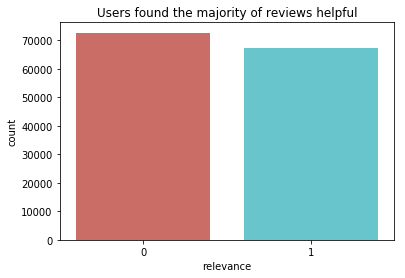

In [65]:
sns.countplot(x='relevance', data=reviews_raw, palette='hls')
plt.title('Users found the majority of reviews helpful')
plt.show()

In [66]:
# Almost equal prpportion 
reviews_raw['relevance'].value_counts()

0    72646
1    67209
Name: relevance, dtype: int64

When making sentiment analysis consider only useful reviews. 

In [67]:
# Keep only relevant reviews for sentiment analysis
reviews_raw = reviews_raw[reviews_raw.relevance == 1]

In [68]:
# our data points are greatly reduced now 
reviews_raw.shape

(67209, 12)

In [69]:
# Take the ratings column and divide in to positive and negative sentiment by assigning 1 to high rating ones
# and 0 for ratings lower than 3 

# Don't run this twice!!!!! Every value will be zero otherwise 
# The order in which these two cells run matters too. lower class first 
reviews_raw['overall']=np.where(reviews_raw['overall'] <= 3, 0, reviews_raw['overall'].astype(int))

In [70]:
reviews_raw['overall']=np.where(reviews_raw['overall'] > 3, 1, reviews_raw['overall'].astype(int))

In [73]:
# Only relevant reviews 
reviews_raw.head(3)

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,relevance_Numerator,relevance_Denominator,relevance
4,0700099867,"[2, 2]",1,I had Dirt 2 on Xbox 360 and it was an okay ga...,"06 14, 2011",A361M14PU2GUEG,"Angry Ryan ""Ryan A. Forrest""",DIRT 3,1308009600,2,2,1
6,0700099867,"[11, 13]",1,Loved playing Dirt 2 and I thought the graphic...,"08 14, 2011",AN3YYDZAS3O1Y,Bob,A step up from Dirt 2 and that is terrific!,1313280000,11,13,1
9,0700099867,"[1, 1]",0,I still haven't figured this one out. Did ever...,"02 8, 2014",A2JLT2WY0F2HVI,D. Sweetapple,Couldn't get this one to work,1391817600,1,1,1


### Fix Class imbalance 

Most of the reviews have positive sentiment. We need to represent the same number of reviews in each class. We'll do so by downsampling the majority class to mathch with the minority class. We will loose information on the process. The alternative is up sampling by which we increase the number of the minority class by randomly selecting and adding uo to match the majority group or anything in between. This would result in a lesser loss of information but since we have limited computational power, the downsampling method will work better for us. 

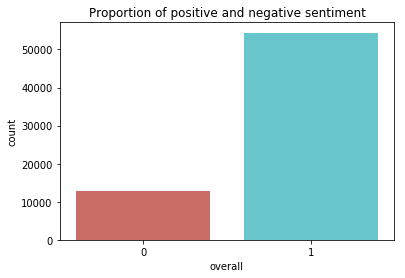

1    54410
0    12799
Name: overall, dtype: int64


In [74]:
# visualize the difference and count each class 
sns.countplot(x='overall', data=reviews_raw, palette='hls')
plt.title('Proportion of positive and negative sentiment')
plt.show()
print(reviews_raw['overall'].value_counts())

1    12799
0    12799
Name: overall, dtype: int64
We now have a sample with balanced class


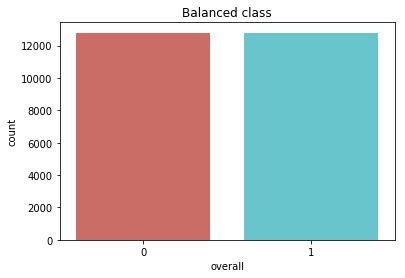

In [75]:
#Import module and resampling 

from sklearn.utils import resample

# Separate majority and minority classes
reviews_raw_majority = reviews_raw[reviews_raw.overall==1]
reviews_raw_minority = reviews_raw[reviews_raw.overall==0]
 
# Downsample majority overall class
reviews_raw_majority_downsampled = resample(reviews_raw_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=12799,     # len(reviews_raw_minority)
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority overall class
reviews_raw_resampled = pd.concat([reviews_raw_majority_downsampled, reviews_raw_minority])
 
# Display new class counts
print(reviews_raw_resampled.overall.value_counts())
print('We now have a sample with balanced class')

sns.countplot(x='overall', data=reviews_raw_resampled, palette='hls')
plt.title('Balanced class')
plt.show()

## Preparing for modeling 

What we want to do with our models is, as mentioned, predict the sentiment based on the reviews text. As a result we will keep the 'reviewsText' and 'overall' columns of our dataset and ignore the others which helped us refine our data. 

In [77]:
# Keep only these two 
reviews = reviews_raw_resampled[['reviewText', 'overall']]

In [78]:
reviews.tail()

,reviewText,overall
231666,For something advertised as &#34;PlayPad Pro f...,0
231774,The real Mario Kart 8 Wii U bundle is a red bo...,0
231777,The package should have more red on it and sho...,0
231778,Can get this at Newegg for $329.00 and the pac...,0
231779,"This is not real, you can go to ANY retail sto...",0


# apply NLP

In [79]:
reviews.head()

,reviewText,overall
52020,fast delivery. I never get sick of this game. ...,1
102036,"First, I came late to Mass Effect (ME). I ori...",1
164051,I liked this game. Even though other reviewers...,1
126540,I was a little skeptical at first about playin...,1
52835,Atelier Iris is a truly incredible accomplishm...,1


## Feature generation and selection

We will apply TFIDF (Term Frequency–Inverse Document Frequency) to weigh the importance of each word in a review. tf–idf works by assigning a value to each word based on how many times the word appears in the review. The value is offset by the number of reviews in our collection that contain the word.

Before we generate our features, we will clean the data set using SnowballStemmer and stopwords. The former removes affixes from words and returns onlt the stem. The latter removes common words such as 'the' which apear frequently and don't have any use for classification or any language analysis.

In [80]:
# initialize 
stemmer = SnowballStemmer('english')
words = stopwords.words("english")

In [81]:
# clean our text data by applying the tools above and also keeping only characters A-Z  
reviews['cleaned'] = reviews['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

C:\Users\Omistaja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [82]:
# We have a cleaned version of the reviews 
reviews.head()

,reviewText,overall,cleaned
52020,fast delivery. I never get sick of this game. ...,1,fast deliveri i never get sick game i nintendo...
102036,"First, I came late to Mass Effect (ME). I ori...",1,first i came late mass effect me i origin boug...
164051,I liked this game. Even though other reviewers...,1,i like game even though review said game easi ...
126540,I was a little skeptical at first about playin...,1,i littl skeptic first playingdj hero bundl tur...
52835,Atelier Iris is a truly incredible accomplishm...,1,ateli iri truli incred accomplish everyth coul...


In [83]:
# our x and y
X = reviews['cleaned']
Y = reviews['overall']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [65]:
X_train_tf.shape

(17918, 1191294)

In [85]:
# initialize tfidf with max_features of 10000 
tf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_df=0.5, sublinear_tf=True, max_features=10000)

In [86]:
# fit and transform 
X_train_tf=tf.fit_transform(X_train)
X_test_tf=tf.transform(X_test)

In [68]:
X_train_tf.shape

(17918, 10000)

# The models and Evaluation 

We'll use a number of supervised learning methods to predict sentiment. We'll use the accuracy score, confusion matrrix and ROC, and run time to compare the models. 

# Bernoulli

In [87]:
# bernoulli
start_time = time.clock()
mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train)
y_Naive = mnb.predict(X_test_tf)

Training set score: 0.8320683111954459

Test set score: 0.789453125
Confusion matrix
[[2966  851]
 [ 766 3097]]


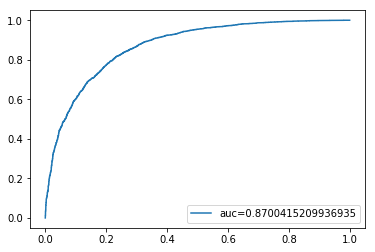

--- 4.546360667544461 seconds ---


In [70]:
# score

print('Training set score:', mnb.score(X_train_tf, y_train))
print('\nTest set score:', mnb.score(X_test_tf, y_test))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_test, y_Naive))

# AUC 
y_pred_proba = mnb.predict_proba(X_test_tf)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time))

# knn

In [88]:
# Fit the data to knn model 
start_time2 = time.clock()
neigh = KNeighborsClassifier(n_neighbors=1000, weights='distance')
neigh.fit(X_train_tf, y_train)
y_knn = neigh.predict(X_test_tf)


Training set score: 0.9999441901997991

Test set score: 0.7623697916666666
Confusion matrix
[[3068  749]
 [1076 2787]]


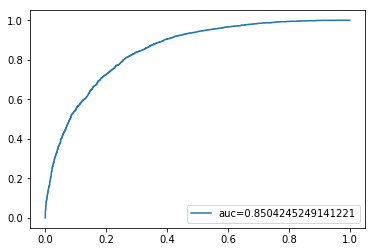

--- 76.74822741333355 seconds ---


In [89]:
# score
print('Training set score:', neigh.score(X_train_tf, y_train))
print('\nTest set score:', neigh.score(X_test_tf, y_test))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_test, y_knn))

# AUC 
y_pred_proba = neigh.predict_proba(X_test_tf)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time2))

In [90]:
# Classification report 
print(classification_report(y_test, y_knn))

             precision    recall  f1-score   support

          0       0.74      0.80      0.77      3817
          1       0.79      0.72      0.75      3863

avg / total       0.76      0.76      0.76      7680



# Decision tree

In [91]:
# Decision tree using GridSearchCV to tune parameters
start_time3 = time.clock()

tree_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150,500]}
tree = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
grid_fit = tree.fit(X_train_tf, y_train)

best_tree = grid_fit.best_estimator_
y_tree = best_tree.predict(X_test_tf)

Training set score: 0.7706775309744391

Test set score: 0.6516927083333334
Confusion matrix
[[2757 1060]
 [1615 2248]]
             precision    recall  f1-score   support

          0       0.63      0.72      0.67      3817
          1       0.68      0.58      0.63      3863

avg / total       0.66      0.65      0.65      7680



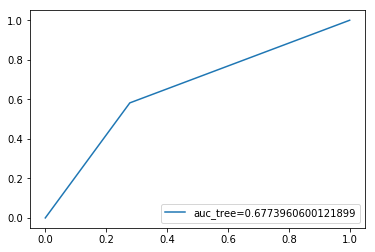

--- 1702.1221267249039 seconds ---


In [74]:
# Evaluations
print('Training set score:', best_tree.score(X_train_tf, y_train))
print('\nTest set score:', best_tree.score(X_test_tf, y_test))

#Confusion matrix for decision tree
print('Confusion matrix')
print(confusion_matrix(y_test, y_tree))

# Classification report 
print(classification_report(y_test, y_tree))

# AUC for decision tree classifier
y_tree_proba = tree.predict_proba(X_test_tf)[::,1]
fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test,  y_tree)
auc_tree = metrics.roc_auc_score(y_test, y_tree_proba)
plt.plot(fpr_tree,tpr_tree,label='auc_tree='+str(auc_tree))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time3))

# Random forest

In [75]:
start_time4 = time.clock()
forest_para = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150, 200, 300, 500]}
forest = GridSearchCV(ensemble.RandomForestClassifier(), forest_para, cv=5)
grid_fit_forest = forest.fit(X_train_tf, y_train)

best_forest = grid_fit_forest.best_estimator_
y_forest = best_forest.predict(X_test_tf)

Training set score: 0.9865498381515794

Test set score: 0.712109375
Confusion matrix
[[2946  871]
 [1340 2523]]
             precision    recall  f1-score   support

          0       0.69      0.77      0.73      3817
          1       0.74      0.65      0.70      3863

avg / total       0.72      0.71      0.71      7680



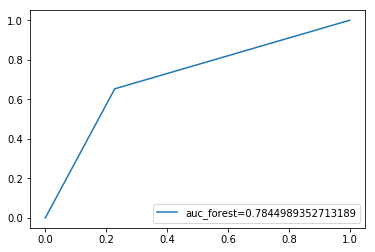

--- 373.9883596998661 seconds ---


In [76]:
# Evaluations
print('Training set score:', best_forest.score(X_train_tf, y_train))
print('\nTest set score:', best_forest.score(X_test_tf, y_test))

#Confusion matrix for random forest
print('Confusion matrix')
print(confusion_matrix(y_test, y_forest))

# Classification report 
print(classification_report(y_test, y_forest))

# AUC for random forest classifier
y_forest_proba = forest.predict_proba(X_test_tf)[::,1]
fpr_forest, tpr_forest, _ = metrics.roc_curve(y_test,  y_forest)
auc_forest = metrics.roc_auc_score(y_test, y_forest_proba)
plt.plot(fpr_forest,tpr_forest,label='auc_forest='+str(auc_forest))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time4))

# Logistics regression

In [92]:
# Binary classification using logistics 
start_time5 = time.clock()
logreg = LogisticRegression()
logreg.fit(X_train_tf, y_train)

# Predict using the test set
y_logreg = logreg.predict(X_test_tf)


Training set score: 0.8783346355620046

Test set score: 0.8109375
Confusion matrix
[[3050  767]
 [ 685 3178]]
             precision    recall  f1-score   support

          0       0.82      0.80      0.81      3817
          1       0.81      0.82      0.81      3863

avg / total       0.81      0.81      0.81      7680



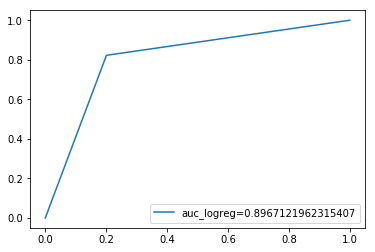

--- 0.769398580226607 seconds ---


In [78]:
# Evaluations
print('Training set score:', logreg.score(X_train_tf, y_train))
print('\nTest set score:', logreg.score(X_test_tf, y_test))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_logreg))

# Classification report 
print(classification_report(y_test, y_logreg))

# AUC classifier
y_logreg_proba = logreg.predict_proba(X_test_tf)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_test,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_test, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time5))

# ridge

In [93]:
# Ridge classifier
start_time6 = time.clock()
ridge = RidgeClassifier()
ridge.fit(X_train_tf, y_train)

y_ridge = ridge.predict(X_test_tf)

In [80]:
# Evaluations
print('Training set score:', ridge.score(X_train_tf, y_train))
print('\nTest set score:', ridge.score(X_test_tf, y_test))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_ridge))

# Classification report 
print(classification_report(y_test, y_ridge))
print("--- %s seconds ---" % (time.clock() - start_time6))

Training set score: 0.9291215537448376

Test set score: 0.8
Confusion matrix
[[3006  811]
 [ 725 3138]]
             precision    recall  f1-score   support

          0       0.81      0.79      0.80      3817
          1       0.79      0.81      0.80      3863

avg / total       0.80      0.80      0.80      7680

--- 0.9024526464809242 seconds ---


# lasso

In [94]:
start_time7 = time.clock()
lasso = LogisticRegression(penalty='l1')
lasso.fit(X_train_tf, y_train)

y_lasso = lasso.predict(X_test_tf)

Training set score: 0.8367563344123228

Test set score: 0.8061197916666667
Confusion matrix
[[3039  778]
 [ 711 3152]]
             precision    recall  f1-score   support

          0       0.81      0.80      0.80      3817
          1       0.80      0.82      0.81      3863

avg / total       0.81      0.81      0.81      7680



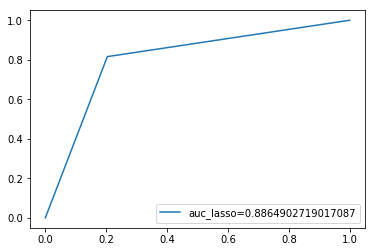

--- 0.6023443586659596 seconds ---


In [82]:
# Evaluations
print('Training set score:', lasso.score(X_train_tf, y_train))
print('\nTest set score:', lasso.score(X_test_tf, y_test))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_lasso))

# Classification report 
print(classification_report(y_test, y_lasso))

# AUC
y_lasso_proba = lasso.predict_proba(X_test_tf)[::,1]
fpr_lasso, tpr_lasso, _ = metrics.roc_curve(y_test,  y_lasso)
auc_lasso = metrics.roc_auc_score(y_test, y_lasso_proba)
plt.plot(fpr_lasso,tpr_lasso,label='auc_lasso='+str(auc_lasso))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time7))

# SVM

In [83]:
# Set the parameters by cross-validation
# reference http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
start_time8 = time.clock()
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'C': [1, 10, 100, 500]}]
clf = GridSearchCV(SVC(probability=True), tuned_parameters, cv=5)
clf.fit(X_train_tf, y_train)

clf.best_params_

#best_forest = grid_fit_forest.best_estimator_
y_svc = clf.predict(X_test_tf)

Training set score: 0.8593034936934926

Test set score: 0.808984375
Confusion matrix
[[3007  810]
 [ 657 3206]]
             precision    recall  f1-score   support

          0       0.82      0.79      0.80      3817
          1       0.80      0.83      0.81      3863

avg / total       0.81      0.81      0.81      7680



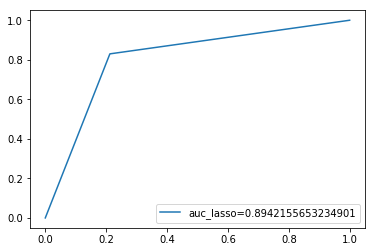

--- 87717.4330868342 seconds ---


In [ ]:
# Evaluations
print('Training set score:', clf.score(X_train_tf, y_train))
print('\nTest set score:', clf.score(X_test_tf, y_test))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_test, y_svc))

# Classification report 
print(classification_report(y_test, y_svc))

# AUC
y_svc_proba = clf.predict_proba(X_test_tf)[::,1]
fpr_clf, tpr_clf, _ = metrics.roc_curve(y_test,  y_svc)
auc_svc = metrics.roc_auc_score(y_test, y_svc_proba)
plt.plot(fpr_clf,tpr_clf,label='auc_lasso='+str(auc_svc))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time8))

The different variations of Logistics regression model (rigdge, lasso, and vanilla logistics regressions) have almost similar performance and are better than the rest. They also took short run time. SVM is not suited for big dataset as it requires that the whole dataset fits memory. The runtime was just over 24 hours. The rest of the algorithms were prone to overfitting and as a result gave a less reliable result. 

## Comparing the reviews across categories 

We will use Pet supplies review data and use the models we used above to see if a model for one category can be used to predict sentiment in other categories. We'll clean and prepare the data similar way. The two data sets have similar structures and columns. Only the entries are different. 

In [7]:
# Load the data
petReviews = pd.read_json('Pet_Supplies_5.json', lines=True, encoding='utf-8')

petReviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1223000893,"[0, 0]",3,I purchased the Trilogy with hoping my two cat...,"01 12, 2011",A14CK12J7C7JRK,Consumer in NorCal,Nice Distraction for my cats for about 15 minutes,1294790400
1,1223000893,"[0, 0]",5,There are usually one or more of my cats watch...,"09 14, 2013",A39QHP5WLON5HV,Melodee Placial,Entertaining for my cats,1379116800
2,1223000893,"[0, 0]",4,I bought the triliogy and have tested out all ...,"12 19, 2012",A2CR37UY3VR7BN,Michelle Ashbery,Entertaining,1355875200
3,1223000893,"[2, 2]",4,My female kitty could care less about these vi...,"05 12, 2011",A2A4COGL9VW2HY,Michelle P,Happy to have them,1305158400
4,1223000893,"[6, 7]",3,"If I had gotten just volume two, I would have ...","03 5, 2012",A2UBQA85NIGLHA,"Tim Isenhour ""Timbo""",You really only need vol 2,1330905600


In [8]:
petReviews[['relevance_Numerator','relevance_Denominator']] = pd.DataFrame(petReviews.helpful.values.tolist(), index = petReviews.index)

In [9]:
# Zero people found this review important 
petReviews= petReviews[petReviews['relevance_Denominator'] > 0]

In [10]:
petReviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,relevance_Numerator,relevance_Denominator
3,1223000893,"[2, 2]",4,My female kitty could care less about these vi...,"05 12, 2011",A2A4COGL9VW2HY,Michelle P,Happy to have them,1305158400,2,2
4,1223000893,"[6, 7]",3,"If I had gotten just volume two, I would have ...","03 5, 2012",A2UBQA85NIGLHA,"Tim Isenhour ""Timbo""",You really only need vol 2,1330905600,6,7
5,4847676011,"[10, 10]",5,"My Rottie has food allergies to poultry, beef ...","07 13, 2007",A2V3UP9NPMHVKJ,"Alex Thomas ""Tommy""",Great for Pups with Food Allergies,1184284800,10,10
6,4847676011,"[2, 2]",5,My puppy loves this stuff! His tail starts wag...,"11 16, 2013",A2R4JCEFLTFU8F,"goldilox ""goldi""",Naturally Yummy!,1384560000,2,2
7,4847676011,"[2, 2]",4,My toy poodle loves this stuff and will let me...,"03 9, 2014",A14B4MJ7KZE63B,K Young,bought to help with dog breath,1394323200,2,2


In [11]:
# Make a score of the 'helpful' rating max value is 1. This number can be used to filter out non helpful reviews based on a 
# treshold. In our case we will just use a helpful index of 75%. Just a small majority vote
petReviews['relevance'] = np.where(petReviews['relevance_Denominator'] > 0, petReviews['relevance_Numerator'] / petReviews['relevance_Denominator'], -1)

In [12]:
petReviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,relevance_Numerator,relevance_Denominator,relevance
3,1223000893,"[2, 2]",4,My female kitty could care less about these vi...,"05 12, 2011",A2A4COGL9VW2HY,Michelle P,Happy to have them,1305158400,2,2,1.000000
4,1223000893,"[6, 7]",3,"If I had gotten just volume two, I would have ...","03 5, 2012",A2UBQA85NIGLHA,"Tim Isenhour ""Timbo""",You really only need vol 2,1330905600,6,7,0.857143
5,4847676011,"[10, 10]",5,"My Rottie has food allergies to poultry, beef ...","07 13, 2007",A2V3UP9NPMHVKJ,"Alex Thomas ""Tommy""",Great for Pups with Food Allergies,1184284800,10,10,1.000000
6,4847676011,"[2, 2]",5,My puppy loves this stuff! His tail starts wag...,"11 16, 2013",A2R4JCEFLTFU8F,"goldilox ""goldi""",Naturally Yummy!,1384560000,2,2,1.000000
7,4847676011,"[2, 2]",4,My toy poodle loves this stuff and will let me...,"03 9, 2014",A14B4MJ7KZE63B,K Young,bought to help with dog breath,1394323200,2,2,1.000000


In [13]:
# relevant vs non relevant reviews. we'll drop non relevant reviews and then use overall score to separate 
# positive and negative sentiment. 

petReviews['relevance']=np.where(petReviews['relevance'] >= 0.75, 1, petReviews['relevance'].astype(int))
petReviews['relevance']=np.where(petReviews['relevance'] < 0.75, 0, petReviews['relevance'].astype(int))

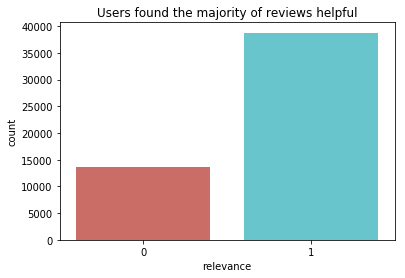

In [14]:
sns.countplot(x='relevance', data=petReviews, palette='hls')
plt.title('Users found the majority of reviews helpful')
plt.show()

In [15]:
petReviews['relevance'].value_counts()

1    38787
0    13681
Name: relevance, dtype: int64

In [16]:
#reviews_raw = reviews_raw['reviews_raw.relevance == 1']
petReviews = petReviews[petReviews.relevance == 1]

In [17]:
# Take the ratings column and divide in to positive and negative sentiment by assigning 1 to high rating ones
# and 0 for ratings lower than 3.5 

# Don't run this twice!!!!! Every value will be zero otherwise 
#reviews_raw['overall']=np.where(reviews_raw['overall'] > 3, 1, reviews_raw['overall'].astype(int))
#reviews_raw['overall']=np.where(reviews_raw['overall'] <= 3, 0, reviews_raw['overall'].astype(int))

# The order in which these two rows run matters too. lower class firse 
petReviews['overall']=np.where(petReviews['overall'] <= 3, 0, petReviews['overall'].astype(int))

In [18]:
petReviews['overall']=np.where(petReviews['overall'] > 3, 1, petReviews['overall'].astype(int))

In [19]:
petReviews.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,relevance_Numerator,relevance_Denominator,relevance
3,1223000893,"[2, 2]",1,My female kitty could care less about these vi...,"05 12, 2011",A2A4COGL9VW2HY,Michelle P,Happy to have them,1305158400,2,2,1
4,1223000893,"[6, 7]",0,"If I had gotten just volume two, I would have ...","03 5, 2012",A2UBQA85NIGLHA,"Tim Isenhour ""Timbo""",You really only need vol 2,1330905600,6,7,1
5,4847676011,"[10, 10]",1,"My Rottie has food allergies to poultry, beef ...","07 13, 2007",A2V3UP9NPMHVKJ,"Alex Thomas ""Tommy""",Great for Pups with Food Allergies,1184284800,10,10,1
6,4847676011,"[2, 2]",1,My puppy loves this stuff! His tail starts wag...,"11 16, 2013",A2R4JCEFLTFU8F,"goldilox ""goldi""",Naturally Yummy!,1384560000,2,2,1
7,4847676011,"[2, 2]",1,My toy poodle loves this stuff and will let me...,"03 9, 2014",A14B4MJ7KZE63B,K Young,bought to help with dog breath,1394323200,2,2,1


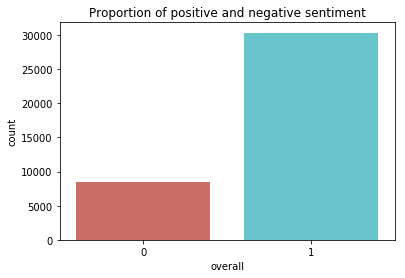

1    30346
0     8441
Name: overall, dtype: int64


In [20]:
sns.countplot(x='overall', data=petReviews, palette='hls')
plt.title('Proportion of positive and negative sentiment')
plt.show()
print(petReviews['overall'].value_counts())

# fixing class imbalance 

1    8441
0    8441
Name: overall, dtype: int64
We now have a sample with balanced class


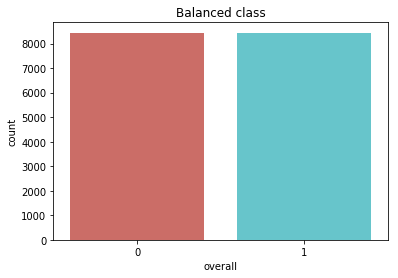

In [21]:
#Import module and resampling 

from sklearn.utils import resample

# Separate majority and minority classes
petReviews_majority = petReviews[petReviews.overall==1]
petReviews_minority = petReviews[petReviews.overall==0]
 
# Downsample majority overall class
petReviews_majority_downsampled = resample(petReviews_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=8441,     # len(reviews_raw_minority)
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority overall class
petReviews_resampled = pd.concat([petReviews_majority_downsampled, petReviews_minority])
 
# Display new class counts
print(petReviews_resampled.overall.value_counts())
print('We now have a sample with balanced class')

sns.countplot(x='overall', data=petReviews_resampled, palette='hls')
plt.title('Balanced class')
plt.show()

In [25]:
petReviews = petReviews_resampled[['reviewText', 'overall']]

In [28]:
petReviews.head()

,reviewText,overall,cleaned
70588,My Bichon Frise's tear stains were getting ver...,1,my bichon frise tear stain get bad late vet re...
149651,We've made the switch from Sojo's (oat based) ...,1,we made switch sojo oat base honest kitchen we...
85384,my rabbit survives only on this food now as he...,1,rabbit surviv food old sick i twas nice go dri...
107956,"Our smart cat isn't interested in the laser, i...",1,our smart cat interest laser instead goe strai...
82162,This is a great product. I have used it a cou...,1,this great product i use coupl time i puppi se...


In [26]:
stemmer = SnowballStemmer('english')
words = stopwords.words("english")

In [27]:
#data['cleaned'] = data['text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())
petReviews['cleaned'] = petReviews['reviewText'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in words]).lower())

C:\Users\Omistaja\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
# our x and y
# X pet as a 
X_pet = petReviews['cleaned']
Y_pet = petReviews['overall']

In [34]:
# bag of words with text vectorizer
tf = TfidfVectorizer(ngram_range=(1, 2), stop_words="english", max_df=0.5, sublinear_tf=True, max_features=10000)

In [49]:
X_pet_tf=tf.fit_transform(X_pet)

In [50]:
X_pet.shape

(16882,)

In [51]:
X_pet_tf.shape

(16882, 10000)

# Models

Since our model is already trained, we'll only fit the new data to predict the sentiment

# Bernoulli

In [126]:
# bernoulli
start_time = time.clock()
y_Naive_pet = mnb.predict(X_pet_tf)


Test set score: 0.48459898116336925
Confusion matrix
[[3444 4997]
 [3704 4737]]
             precision    recall  f1-score   support

          0       0.48      0.41      0.44      8441
          1       0.49      0.56      0.52      8441

avg / total       0.48      0.48      0.48     16882



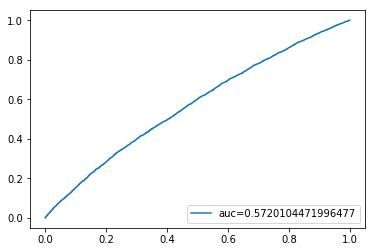

--- 0.5242534400003933 seconds ---


In [127]:
# Evaluation

print('\nTest set score:', mnb.score(X_pet_tf, Y_pet))
#score = cross_val_score(mnb, X, Y, cv=10)
#print(score)

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(Y_pet, y_Naive_pet))

# Classification report 
print(classification_report(Y_pet, y_Naive_pet))

# AUC 
y_pred_p = mnb_pet.predict_proba(X_pet_tf)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_pet,  y_pred_p)
auc = metrics.roc_auc_score(Y_pet, y_pred_p)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time))

# Knn

In [124]:
# Fit the data to knn model 
start_time2 = time.clock()
y_knn_pet = neigh.predict(X_pet_tf)


Test set score: 0.5419381589859021
Confusion matrix
[[3818 4623]
 [4238 4203]]
             precision    recall  f1-score   support

          0       0.47      0.45      0.46      8441
          1       0.48      0.50      0.49      8441

avg / total       0.48      0.48      0.47     16882



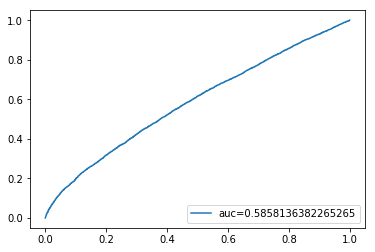

--- 34.790545919999204 seconds ---


In [125]:
# Evaluation
print('\nTest set score:', neigh_pet.score(X_pet_tf, Y_pet))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(Y_pet, y_knn_pet))

# Classification report 
print(classification_report(Y_pet, y_knn_pet))

# AUC 
y_pred_proba = neigh_pet.predict_proba(X_pet_tf)[::,1]
fpr, tpr, _ = metrics.roc_curve(Y_pet,  y_pred_proba)
auc = metrics.roc_auc_score(Y_pet, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time2))

# Logistics regression

In [106]:
# Binary classification using logistics regression
start_time5 = time.clock()
y_logreg_pet = logreg.predict(X_pet_tf)


Test set score: 0.5633811159815187
Confusion matrix
[[4005 4436]
 [4166 4275]]
             precision    recall  f1-score   support

          0       0.49      0.47      0.48      8441
          1       0.49      0.51      0.50      8441

avg / total       0.49      0.49      0.49     16882



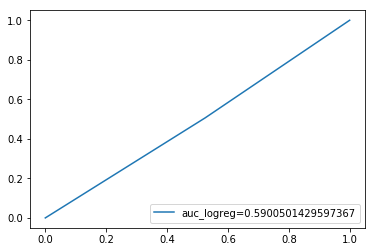

--- 0.4734839466673293 seconds ---


In [107]:
# Evaluations
print('\nTest set score:', logreg_pet.score(X_pet_tf, Y_pet))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(Y_pet, y_logreg_pet))

# Classification report 
print(classification_report(Y_pet, y_logreg_pet))

# AUC classifier
y_logreg_proba = logreg_pet.predict_proba(X_pet_tf)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(Y_pet,  y_logreg_pet)
auc_logreg = metrics.roc_auc_score(Y_pet, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time5))

# Ridge

In [114]:
# Ridge classifier
start_time6 = time.clock()
y_ridge_pet = ridge.predict(X_pet_tf)

In [115]:
# Evaluations
print('\nTest set score:', ridge.score(X_pet_tf, Y_pet))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(Y_pet, y_ridge_pet))

# Classification report 
print(classification_report(Y_pet, y_ridge_pet))
print("--- %s seconds ---" % (time.clock() - start_time6))


Test set score: 0.4928918374600166
Confusion matrix
[[3968 4473]
 [4088 4353]]
             precision    recall  f1-score   support

          0       0.49      0.47      0.48      8441
          1       0.49      0.52      0.50      8441

avg / total       0.49      0.49      0.49     16882

--- 0.35272746666669264 seconds ---


# lasso

In [122]:
start_time7 = time.clock()
y_lasso_pet = lasso.predict(X_pet_tf)


Test set score: 0.5017178059471626
Confusion matrix
[[4448 3993]
 [4419 4022]]
             precision    recall  f1-score   support

          0       0.50      0.53      0.51      8441
          1       0.50      0.48      0.49      8441

avg / total       0.50      0.50      0.50     16882



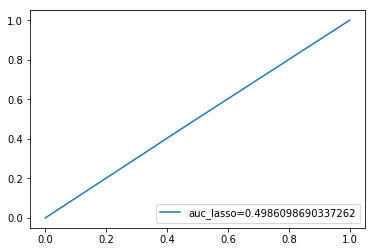

--- 0.42797823999899265 seconds ---


In [123]:
# Evaluations
print('\nTest set score:', lasso.score(X_pet_tf, Y_pet))

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(Y_pet, y_lasso_pet))

# Classification report 
print(classification_report(Y_pet, y_lasso_pet))

# AUC
y_lasso_proba = lasso.predict_proba(X_pet_tf)[::,1]
fpr_lasso, tpr_lasso, _ = metrics.roc_curve(Y_pet,  y_lasso_pet)
auc_lasso = metrics.roc_auc_score(Y_pet, y_lasso_proba)
plt.plot(fpr_lasso,tpr_lasso,label='auc_lasso='+str(auc_lasso))
plt.legend(loc=4)
plt.show()
print("--- %s seconds ---" % (time.clock() - start_time7))

### Comparison

None of the models performed good in all measures when used to predict the new data set. 

# Conclusion 

We started with a review dataset of more than 230K entries but, the size was reduced significantly to about 18K mostly due to the need to adjust for computation power. We generated more than 1.7M featues using tf-idf vectorizer which was reduced to only 10K for the same reason. These reductions will have affected the performance of some of the models we used such as decision tree and random forest. This could also be one reason why the models were not able to predict sentiment of the pet supplies data set. 

But based on the analysis we made, logistics regression models are recommended for sentiment analysis. We can also conclude that a classification model for one category does not work for another. 